## Introduction

Le but de cette activité est de faire un clustering d’images représentant des chiffres manuscrits, en python. Le jeu de données est constitué d'images extraites du jeu de données MNIST, dont on n'utilisera qu'une image sur cinquante.

Ces données sont téléchargeables à l'emplacement suivant: https://github.com/amplab/datascience-sp14/raw/master/lab7/mldata/mnist-original.mat 

Pour cela, on suivra le cheminement suivant:

**Première partie** : Analyse et traitement préliminaire des données.<br>
**Deuxième partie** : Partitionnement du dataset via les algorithmes k-means et DBSCAN.<br>
**Troisième partie** : Visualisation des clusterings obtenus en deux dimensions.<br>
**Quatrième partie** : Evaluation de la qualité de chacun des deux partitionnements et choix d'un algorithme.<br>


## I. Analyse et traitement préliminaire des données

On commence par charger les données, les explorer superficiellement et effectuer quelques traitements préliminaires. 

In [1]:
# Import des librairies nécessaires
import scipy.io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import sklearn

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import davies_bouldin_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

random_state = 24
warnings.filterwarnings('ignore')

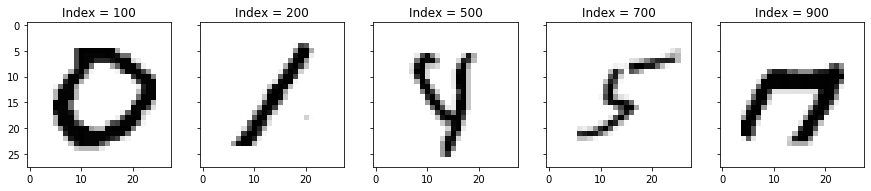

In [2]:
# Import des données du dataset mnist
custom_data_home = ''
fichier = 'mnist-original.mat'

mnist = scipy.io.loadmat(custom_data_home + fichier)
X = mnist['data'].T
X = X[::50, :]
X = X.astype(np.float64)
y = mnist['label'].T
y = y[::50]
y = y.reshape(-1)

# Fonction de visualisation des images du dataset.
def visualiser_observation(sample_idx, ax):
    sample_image = np.reshape(X[sample_idx, :], (28, 28))
    ax.imshow(sample_image, cmap='binary')
    ax.set_title('Index = {}'.format(sample_idx))
    
# Visualisation de 5 observations au hasard dans le dataset
f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, sharey=True, figsize=(15, 8))

visualiser_observation(100, ax1)
visualiser_observation(200, ax2)
visualiser_observation(500, ax3)
visualiser_observation(700, ax4)
visualiser_observation(900, ax5)

plt.show()


## II. Partitionnement du dataset via k-means et DBSCAN
On tente de trouver un clustering de ces données via deux algorithmes: l'algorithme k-means avec k=10 clusters, et DBSCAN. DBSCAN ne permet pas de sélectionner le nombre de clusters a priori.  

Voici quelques remarques sur l'utilisation de DBSCAN sur le dataset:
- En grande dimension, DBSCAN ne fonctionne pas très bien; en effet, la plupart des boules unités de rayon $\epsilon$ étant vides, beaucoup de points sont alors identifiés comme isolés, et donc comme du bruit. Afin de s'affranchir de ce *fléau de la dimension*, on a donc tout d'abord réduit les données en 3 dimensions par un t-SNE. Le désavantage est que l'on dépend de la qualité de la réduction de dimension effectuée.<br><br>

- On a ensuite essayé plusieurs couples de valeurs pour les paramètres n et $\epsilon$. On a tenté empiriquement d'optimiser ces valeurs jusqu'à ce qu'un nombre raisonnable de clusters aparaîsse, et que le nombre de points classifiés comme bruit soit assez bas. <br><br>

- Une manière plus propre d'optimiser le choix des paramètres de DBSCAN et de la dimension de l'espace sur lequel l'appliquer aurait été de développer une recherche sur grille dédiée (GridSearchCV de sklearn ne s'appliquant pas aux algorithmes de clustering).

In [3]:
# Clustering via k_means avec k = 10
kmeans = KMeans(n_clusters=10, random_state=random_state)
kmeans.fit(X)

#On normalise les données avant d'appliquer t-SNE
X_3D = StandardScaler().fit_transform(X)

# On applique T-SNE
tsne = TSNE(n_components=3, random_state=random_state)
X_3D = tsne.fit_transform(X_3D)

# Clustering via DBSCAN
dbscan = DBSCAN(eps=3.3, min_samples=5)
dbscan.fit(X_3D)

DBSCAN(algorithm='auto', eps=3.3, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=5, n_jobs=None, p=None)

K-mean et DBSCAN ont chacun permis de trouver k clusters numérotés de 0 à k-1. Seulement, le cluster étiqueté 0 ne correspond pas forcément aux images du chiffre 0. On réétiquette donc les clusters en leur assignant le chiffre le plus fréquent au sein du cluster.

In [4]:
def plus_frequent(liste): 
    """
    Renvoie l'élement le plus fréquent dans liste.
    """
    return max(set(liste), key = liste.count) 

def label_majoritaire(repartition):
    """
    Pour une répartition donnée en n clusters, renvoie le label le plus fréquent 
    au sein de chacun des n clusters.
    On ne touche pas aux observations classifiées comme du bruit 
    c-à-d celles dont label_ = -1.
    """
    labels = repartition.labels_
    labeled_clusters = {}
    for l in set(labels).difference({-1}):
        real_labels = [y[i] for (i, ind) in enumerate(labels) if labels[i] == l]
        labeled_clusters[l] = plus_frequent(real_labels)
    return labeled_clusters

km_clusters = label_majoritaire(kmeans)
y_pred_km = [km_clusters[l] for l in kmeans.labels_]

db_clusters = label_majoritaire(dbscan)
db_clusters[-1]=-1
y_pred_db = [db_clusters[l] for l in dbscan.labels_]

## III. Visualisation en deux dimensions

On a stocké, dans le dictionnaire km_clusters (resp. db_clusters), le label le plus fréquent au sein de chaque cluster défini par k-means (resp. DBSCAN). Pour déterminer le chiffre qui serait prédit par k-means ou DBSCAN pour une observation donnée, on regarde à quel cluster elle appartient le plus probablement, et on renvoie le label le plus fréquent dans ce cluster. 

On visualise les résultats en deux dimensions:
- Dans le plot de gauche, on affiche les chiffres réellement représentés par les images.
- Dans le plot central, on affiche le cluster assigné par k-means, ainsi que le label le plus fréquent dans ce cluster. <br>
- Dans le plot de droite, on affiche le cluster assigné par DBSCAN, ainsi que le label le plus fréquent dans ce cluster. <br>
- Pour plus de lisibilité, dans les trois plots, les couleurs utilisées pour représenter un même label sont les mêmes. Les observations classées comme bruit par DBSCAN sont représentées en noir.

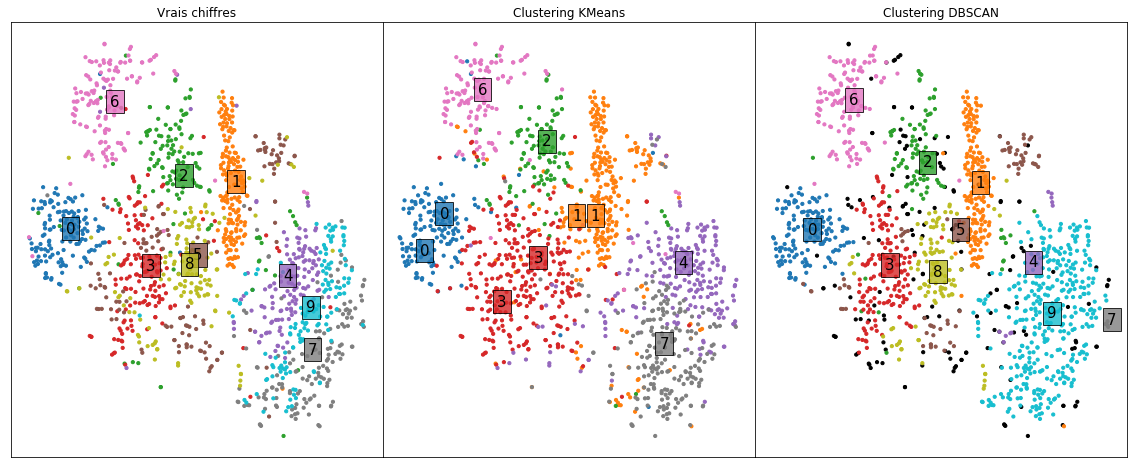

In [5]:
# On réduit la dimension des données à 2 dimensions via un nouveau t-SNE
# On inclut aussi les centres des clusters de kmeans 
# pour pouvoir les représenter plus tard dans cet espace.
all_points = pd.concat([pd.DataFrame(X), pd.DataFrame(kmeans.cluster_centers_)])

# On normalise les données avant d'appliquer t-SNE
all_points = StandardScaler().fit_transform(all_points)

# On applique T-SNE
tsne = TSNE(n_components=2, random_state=random_state)
all_points = tsne.fit_transform(all_points)

# On ré-isole le dataset sans les centres des clusters de k-means
X_2D = pd.DataFrame(all_points[:-10, :])
X_2D = X_2D.rename({0: 'dimension1', 1: 'dimension2'}, axis='columns')
X_2D['truelabels'] = y
X_2D['kmeans'] = y_pred_km
X_2D['dbscan'] = y_pred_db

# Pour faciliter la visualisation, on stocke, pour chaque chiffre, les barycentres 
# des images représentant ce chiffre dans l'espace en 2 dimensions
centers_real = X_2D.groupby('truelabels').agg('mean')
centers_real.drop(labels=['kmeans', 'dbscan'], axis=1, inplace=True)
centers_real.reset_index(inplace=True)
centers_real.rename(columns={'truelabels': 'label'}, inplace=True)
centers_real['label'] = centers_real['label'].apply(lambda l : str(int(l)))

# On stocke les centre des clusters ramenés par k-means dans l'espace en 2 dimensions
centers_kmeans = pd.DataFrame(all_points[-10:, :])
centers_kmeans.rename({0: 'dimension1', 1: 'dimension2'}, axis='columns', inplace=True)
centers_kmeans['label'] = [str(int(v)) for v in km_clusters.values()]

# On stocke les centre des clusters ramenés par DBSCAN dans l'espace en 2 dimensions
centers_dbscan = X_2D.groupby('dbscan').agg('mean')
centers_dbscan.drop(labels=['kmeans', 'truelabels'], axis=1, inplace=True)
centers_dbscan.reset_index(inplace=True)
centers_dbscan.rename(columns={'dbscan': 'label'}, inplace=True)
centers_dbscan['label'] = centers_dbscan['label'].apply(lambda l : str(int(l)))

# On représente les données
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(20, 8))

plt.subplots_adjust(wspace=0, hspace=0)

def convert_to_color(label):
    """
    Trouver la couleur correspondant au label donné.
    """
    if int(label) != -1:
        couleur = plt.cm.tab10(int(label)/10.)
    else:
        couleur = 'black'
    return couleur

def visualiser_clusters(ax, column, title, X_2D, centers):
    """
    Visualisation des résultats en deux dimensions.
    """
    # On retraite le dataset pour colorer les points du plot. 
    # NB : on représente le bruit en noir.
    X_2D['colors'] = X_2D[column].apply(convert_to_color)
    centers['colors'] = centers['label'].apply(convert_to_color)
    centers = centers[centers['label']!='-1']
    
    # On  crée le plot
    for i, X_nb in X_2D.groupby(column):
        ax.scatter(X_nb['dimension1'], X_nb['dimension2'], s=10, color=X_nb['colors'])     
                    
    # On affiche le centre de chaque cluster avec le chiffre majoritaire
    for index, center in centers.iterrows():
        ax.text(center['dimension1'], center['dimension2'], center['label'], fontsize=15,
                bbox=dict(facecolor=center['colors'], alpha=0.8))
        
    # On ajoute un titre au plot
    ax.set_title(title)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

            
visualiser_clusters(ax1, 'truelabels', 'Vrais chiffres', X_2D, centers_real)
visualiser_clusters(ax2, 'kmeans', 'Clustering KMeans', X_2D, centers_kmeans)
visualiser_clusters(ax3, 'dbscan', 'Clustering DBSCAN', X_2D, centers_dbscan)

plt.show()

## IV. Analyse et évaluation

### Analyse qualitative

En analysant visuellement les plots, on peut formuler certaines remarques. <br><br>
**Plot des labels réels des données (gauche):**
- Les images représentant le même chiffre sont voisines : la réduction de dimension effectuée via t-SNE a assez bien conservé la proximité entre images de même label.<br>


**Plot de la prédiction k-means (centre):**
- Globalement, les labels prédits sont plutôt corrects. Même en n'utilisant qu'un chiffre sur 50 dans le dataset, k-means a bien réalisé un clustering permettant d'identifier les groupes d'images représentant un même chiffre.
- Il semble être difficile de distinguer 4 et 9. Cela paraît cohérent car ces deux chiffres sont très proches dans le plot de gauche.
- 5 et 8 semblent tous les deux avoir été absorbés par les clusters avoisinants. 
- Certains chiffres sont majoritaires dans plusieurs clusters. En effet, comme 5, 8 et 9 ne sont pas assez différentiables pour avoir donné lieu à des clusters dédiés, et que k-means a reçu pour consigne de trouver 10 clusters, les clusters de 0, 1 et 3 ont été dédoublés.

**Plot de la prédiction DBSCAN (droite):**
- Comme DBSCAN a effectué son clustering sur la version du dataset réduite en 3 dimensions, les clusters n'ayant pas été bien différenciés par t-SNE n'ont pas pu être correctement identifiés. 
- On observe par ailleurs que les clusters sont très hétérogènes en taille: le cluster de 9 semble avoir absorbé pratiquement toute la population des clusters de 4 et 7.
- Tous les points noirs ont été classifiés comme du bruit: l'algorithme a manifestement eu du mal à assigner tous les points à un cluster donné. 


### Analyse quantitative

On évalue ici quantitativement les résultats obtenus.<br>

On évalue d'abord la qualité des clusters indépendamment des étiquettes réelles grâce aux mesures suivantes:
- *Le coefficient de silhouette moyen*, permettant de mesurer le degré de satisfaction moyen de l'assignation d'un point à son cluster, et d'autant plus proche de 1 que les assignations sont satisfaisantes.
- *L'indice de Davies-Bouldin moyen*, dans la même veine, d'autant plus faible que les points sont proches du centre du cluster auquel ils ont été assignés, et que les centres des clusters sont éloignés.<br>

On évalue ensuite la qualité de la prédiction en tenant compte des étiquettes du training set. Pour cela, on utilisera *l'indice de Rand Ajusté* entre les clusters définis par les labels réels du dataset et ceux proposés par l'algorithme de clustering. Cette quantité est d'autant plus proche de 1 que les deux clusterings sont proches.



In [6]:
evaluation = pd.DataFrame()

evaluation['kmeans'] = pd.Series({'silhouette': silhouette_score(X, y_pred_km),
                                  'davies_bouldin': davies_bouldin_score(X, y_pred_km),
                                  'rand_score': adjusted_rand_score(y, y_pred_km)})

evaluation['dbscan'] = pd.Series({'silhouette': silhouette_score(X, y_pred_db),
                                  'davies_bouldin': davies_bouldin_score(X, y_pred_db),
                                  'rand_score': adjusted_rand_score(y, y_pred_db)})

print(evaluation)

                  kmeans    dbscan
silhouette      0.069786  0.017246
davies_bouldin  2.896600  4.128480
rand_score      0.384103  0.503966


On voit que k-means fait mieux que DBSCAN sur les deux premiers indices: le score de silhouette est d'autant plus bon qu'il est élevé, alors que le score de davies_bouldin est meilleur s'il est proche de 0. Les clusters renvoyés par k-means sont donc de meilleure qualité.

En revanche, le rand-score de DBSCAN est meilleur: si l'on considère le problème comme un problème supervisé, et c'en est un étant donné qu'on connaît les étiquettes des images fournies, le clustering obtenu à partir de DBSCAN permet mieux que celui de k-means de prédire le chiffre dessiné sur l'image. 

### Conclusion

Si l'objectif du modèle est de prédire le chiffre dessiné sur une image, on choisira donc plutôt DBSCAN. Si l'on ne disposait pas des étiquettes, et que le problème était donc non-supervisé, on aurait choisi k-means, dont le clustering proposé semble être de meilleure qualité.